In [1]:
pip install "spacy<3.7" datasets tqdm matplotlib 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!python3 -m spacy download en_core_web_sm


2025-10-08 20:40:44.592888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 20:40:44.740675: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 20:40:44.778847: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 20:40:45.386099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
!python3 -m spacy download de_core_news_sm


2025-10-08 20:40:52.658638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 20:40:52.803869: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 20:40:52.842218: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 20:40:53.451464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
import spacy

# 영어 테스트
nlp_en = spacy.load("en_core_web_sm")
doc_en = nlp_en("A man in a blue shirt is standing on a ladder cleaning a window.")
print([tok.text for tok in doc_en])

# 독일어 테스트
nlp_de = spacy.load("de_core_news_sm")
doc_de = nlp_de("Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.")
print([tok.text for tok in doc_de])


2025-10-08 20:41:02.231092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 20:41:02.399050: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 20:41:02.437911: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 20:41:03.019008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.']
['Ein', 'Mann', 'in', 'einem', 'blauen', 'Hemd', 'steht', 'auf', 'einer', 'Leiter', 'und', 'putzt', 'ein', 'Fenster', '.']


In [5]:
# ============================================
# 1. 라이브러리 임포트 및 설정
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# torchtext 대신 Hugging Face datasets 사용
from datasets import load_dataset

# NLP 관련
import spacy
import numpy as np
import math, time, random
from tqdm import tqdm

# 시각화
import matplotlib.pyplot as plt

# --------------------------------------------
# 디바이스 설정
# --------------------------------------------
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------
# 시드 고정 (재현성 확보)
# --------------------------------------------
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


Using device: cuda:9


In [6]:
# ============================================
# 2. Multi30k 데이터셋 로딩
# ============================================

from datasets import load_dataset

SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"

# 데이터셋 불러오기
dataset = load_dataset("bentrevett/multi30k")

print(dataset)
print(f"\n훈련 데이터 개수: {len(dataset['train'])}")
print(f"검증 데이터 개수: {len(dataset['validation'])}")
print(f"테스트 데이터 개수: {len(dataset['test'])}")

# 샘플 확인
print("\n예시 문장:")
sample = dataset["train"][0]
print(f"독일어 (de): {sample['de']}")
print(f"영어 (en): {sample['en']}")


DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

훈련 데이터 개수: 29000
검증 데이터 개수: 1014
테스트 데이터 개수: 1000

예시 문장:
독일어 (de): Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
영어 (en): Two young, White males are outside near many bushes.


In [7]:
# ============================================
# 3. spaCy 기반 토크나이저 및 어휘 사전 구축
# ============================================

import spacy
from collections import Counter

# spaCy 모델 불러오기 (설치되어 있어야 함)
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

# --------------------------------------------
# 1) 토크나이저 함수 정의
# --------------------------------------------
def tokenize_de(text):
    """독일어 문장을 단어 리스트로 변환"""
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """영어 문장을 단어 리스트로 변환"""
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

# --------------------------------------------
# 2) 어휘 사전(Vocabulary) 구축
# --------------------------------------------
def build_vocab(texts, tokenizer, min_freq=2):
    """주어진 텍스트 리스트로부터 단어 사전 생성"""
    counter = Counter()
    for text in texts:
        counter.update(tokenizer(text))

    vocab = {"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3}
    for word, freq in counter.items():
        if freq >= min_freq and word not in vocab:
            vocab[word] = len(vocab)
    return vocab

# --------------------------------------------
# 3) 실제 어휘 사전 생성
# --------------------------------------------
src_texts = [d["de"] for d in dataset["train"]]
tgt_texts = [d["en"] for d in dataset["train"]]

src_vocab = build_vocab(src_texts, tokenize_de)
tgt_vocab = build_vocab(tgt_texts, tokenize_en)

print(f"독일어 vocab 크기: {len(src_vocab)}")
print(f"영어 vocab 크기: {len(tgt_vocab)}")

# --------------------------------------------
# 4) 특수 토큰 인덱스 저장
# --------------------------------------------
PAD_IDX = src_vocab["<pad>"]
BOS_IDX = src_vocab["<bos>"]
EOS_IDX = src_vocab["<eos>"]
UNK_IDX = src_vocab["<unk>"]

print(f"PAD_IDX={PAD_IDX}, BOS_IDX={BOS_IDX}, EOS_IDX={EOS_IDX}, UNK_IDX={UNK_IDX}")


독일어 vocab 크기: 7853
영어 vocab 크기: 5893
PAD_IDX=1, BOS_IDX=2, EOS_IDX=3, UNK_IDX=0


In [8]:
# ============================================
# 4. DataLoader 구성 및 Collate 함수 정의
# ============================================

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# --------------------------------------------
# 1) 문장을 인덱스 시퀀스로 변환하는 함수
# --------------------------------------------
def encode_sentence(text, vocab, tokenizer):
    """문장을 토큰화하고 각 토큰을 인덱스로 변환"""
    tokens = tokenizer(text)
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    # 문장 시작(<bos>)과 끝(<eos>) 추가
    return torch.tensor([vocab["<bos>"]] + ids + [vocab["<eos>"]], dtype=torch.long)

# --------------------------------------------
# 2) Collate 함수 (배치 단위 데이터 구성)
# --------------------------------------------
def collate_fn(batch):
    """batch: [{'de': ..., 'en': ...}, {...}, ...] 형태"""
    src_batch, tgt_batch = [], []

    for item in batch:
        src_tensor = encode_sentence(item["de"], src_vocab, tokenize_de)
        tgt_tensor = encode_sentence(item["en"], tgt_vocab, tokenize_en)
        src_batch.append(src_tensor)
        tgt_batch.append(tgt_tensor)

    # 문장 길이 맞춰 패딩
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

# --------------------------------------------
# 3) DataLoader 구성
# --------------------------------------------
BATCH_SIZE = 64

train_dataloader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(dataset["validation"], batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader  = DataLoader(dataset["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn)

# --------------------------------------------
# 4) 예시 배치 확인
# --------------------------------------------
src_batch, tgt_batch = next(iter(train_dataloader))
print("입력(src) 배치 크기:", src_batch.shape)
print("출력(tgt) 배치 크기:", tgt_batch.shape)


입력(src) 배치 크기: torch.Size([33, 64])
출력(tgt) 배치 크기: torch.Size([28, 64])


In [9]:
# ============================================
# 5. Positional Encoding 정의
# ============================================

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # [max_len, d_model] 크기의 위치 인코딩 행렬 생성
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        # 짝수 인덱스 → sin, 홀수 인덱스 → cos
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # 입력 x: [batch, seq_len, d_model]
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [10]:
# ============================================
# 6. Transformer 번역 모델 정의
# ============================================

class TransformerTranslationModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, emb_size=512, nhead=8, num_layers=6, ff_dim=2048, dropout=0.1):
        super().__init__()

        # --------------------------------------------
        # 1) 임베딩 (Embedding)
        # --------------------------------------------
        self.src_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout=dropout)

        # --------------------------------------------
        # 2) Transformer 본체
        # --------------------------------------------
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True  # [B, L, D] (배치, 시퀀스 길이, 임베딩 차원)
        )

        # --------------------------------------------
        # 3) 출력층
        # --------------------------------------------
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    # --------------------------------------------
    # forward 함수
    # --------------------------------------------
    def forward(self, src, tgt, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        # --------------------------------------------
        # 임베딩 + 위치 인코딩
        # --------------------------------------------
        src_emb = self.pos_encoder(self.src_emb(src))
        tgt_emb = self.pos_encoder(self.tgt_emb(tgt))

        # --------------------------------------------
        # Transformer 인코더-디코더 통과
        # --------------------------------------------
        output = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask,                       # 미래 단어 차단 (디코더용)
            src_key_padding_mask=src_padding_mask,   # 인코더 패딩 무시
            tgt_key_padding_mask=tgt_padding_mask,   # 디코더 패딩 무시
            memory_key_padding_mask=src_padding_mask # 인코더-디코더 어텐션에서 패딩 무시
        )

        # --------------------------------------------
        # 출력층 (단어별 확률)
        # --------------------------------------------
        return self.generator(output)


In [11]:
# ============================================
# 7. 마스크 생성 함수 정의
# ============================================

def generate_square_subsequent_mask(sz: int):
    """
    디코더용 causal mask (미래 단어 차단)
    shape: [T, T], True = 차단
    """
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)
    return mask

def create_mask(src: torch.Tensor, tgt_in: torch.Tensor, src_pad_idx: int, tgt_pad_idx: int):
    """
    src: [B, S]
    tgt_in: [B, T]  (디코더 입력, 보통 <bos>로 시작하고 마지막 <eos>는 제외)
    반환:
      - tgt_mask: [T, T]
      - src_key_padding_mask: [B, S]  (True가 PAD)
      - tgt_key_padding_mask: [B, T]  (True가 PAD)
    """
    B, T = tgt_in.size()
    tgt_mask = generate_square_subsequent_mask(T).to(tgt_in.device)

    src_key_padding_mask = (src == src_pad_idx)  # [B, S]
    tgt_key_padding_mask = (tgt_in == tgt_pad_idx)  # [B, T]
    return tgt_mask, src_key_padding_mask, tgt_key_padding_mask


In [13]:
# ============================================
# 8. Transformer 모델 초기화
# ============================================

# 소스/타깃 vocab 크기
SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)

# 패딩/시작/끝 토큰 인덱스 분리 (소스/타깃 각각)
SRC_PAD_IDX = src_vocab["<pad>"]; SRC_BOS_IDX = src_vocab["<bos>"]; SRC_EOS_IDX = src_vocab["<eos>"]
TGT_PAD_IDX = tgt_vocab["<pad>"]; TGT_BOS_IDX = tgt_vocab["<bos>"]; TGT_EOS_IDX = tgt_vocab["<eos>"]

# 단어 역변환 사전
tgt_vocab_inv = {v: k for k, v in tgt_vocab.items()}


# 모델 생성
model = TransformerTranslationModel(
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    emb_size=512,      
    nhead=8,
    num_layers=6,      
    ff_dim=2048,
    dropout=0.1
).to(device)

print("모델 준비 완료")


모델 준비 완료


In [15]:
# ============================================
# 9. 손실 함수 + 옵티마이저 + BLEU 평가 포함 학습 루프 (테스트 문장 포함)
# ============================================

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
nltk.download('punkt', quiet=True)

loss_fn = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

NUM_EPOCHS = 10
train_losses, val_losses = [], []
val_bleus = []

# -------------------------------
# (1) BLEU 계산 함수
# -------------------------------
def compute_bleu_score(model, dataloader):
    model.eval()
    preds, refs = [], []
    smoothie = SmoothingFunction().method4

    with torch.no_grad():
        for src_batch, tgt_batch in dataloader:
            src = src_batch.transpose(0, 1).to(device)
            tgt = tgt_batch.transpose(0, 1).to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            tgt_mask, src_kpm, tgt_kpm = create_mask(src, tgt_input, SRC_PAD_IDX, TGT_PAD_IDX)
            logits = model(
                src, tgt_input,
                tgt_mask=tgt_mask,
                src_padding_mask=src_kpm,
                tgt_padding_mask=tgt_kpm,
            )

            pred_ids = logits.argmax(-1).cpu().numpy()
            tgt_ids = tgt_output.cpu().numpy()

            for pred, ref in zip(pred_ids, tgt_ids):
                pred_tokens = [tgt_vocab_inv[i] for i in pred if i not in [TGT_PAD_IDX, TGT_BOS_IDX, TGT_EOS_IDX]]
                ref_tokens  = [tgt_vocab_inv[i] for i in ref if i not in [TGT_PAD_IDX, TGT_BOS_IDX, TGT_EOS_IDX]]
                preds.append(pred_tokens)
                refs.append([ref_tokens])
    return corpus_bleu(refs, preds, smoothing_function=smoothie)


# -------------------------------
# (2) 단일 문장 번역 함수
# -------------------------------
@torch.no_grad()
def translate_sentence(model, sentence_de, max_len=20):
    model.eval()

    # 독일어 문장 토큰화 및 인덱스 변환
    src_tokens = [SRC_BOS_IDX] + [src_vocab.get(tok, src_vocab["<unk>"]) for tok in tokenize_de(sentence_de)] + [SRC_EOS_IDX]
    src_tensor = torch.tensor(src_tokens, dtype=torch.long).unsqueeze(0).to(device)

    # 초기 디코더 입력 (<bos>)
    tgt_tokens = [TGT_BOS_IDX]
    tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(max_len):
        tgt_mask, src_kpm, tgt_kpm = create_mask(src_tensor, tgt_tensor, SRC_PAD_IDX, TGT_PAD_IDX)
        output = model(src_tensor, tgt_tensor, tgt_mask=tgt_mask, src_padding_mask=src_kpm, tgt_padding_mask=tgt_kpm)
        next_token = output[:, -1, :].argmax(-1).item()
        tgt_tokens.append(next_token)
        tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)

        if next_token == TGT_EOS_IDX:
            break

    # 인덱스를 단어로 변환
    translated = [tgt_vocab_inv[idx] for idx in tgt_tokens[1:-1]]  # <bos>, <eos> 제외
    return " ".join(translated)


# -------------------------------
# (3) 학습 루프
# -------------------------------
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for src_batch, tgt_batch in tqdm(train_dataloader, desc=f"[Train] Epoch {epoch}"):
        src = src_batch.transpose(0, 1).to(device)
        tgt = tgt_batch.transpose(0, 1).to(device)

        tgt_input  = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        tgt_mask, src_kpm, tgt_kpm = create_mask(src, tgt_input, SRC_PAD_IDX, TGT_PAD_IDX)

        logits = model(src, tgt_input,
                       tgt_mask=tgt_mask,
                       src_padding_mask=src_kpm,
                       tgt_padding_mask=tgt_kpm)

        optimizer.zero_grad()
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # -------------------------------
    # Validation
    # -------------------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src_batch, tgt_batch in val_dataloader:
            src = src_batch.transpose(0, 1).to(device)
            tgt = tgt_batch.transpose(0, 1).to(device)

            tgt_input  = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            tgt_mask, src_kpm, tgt_kpm = create_mask(src, tgt_input, SRC_PAD_IDX, TGT_PAD_IDX)
            logits = model(
                src, tgt_input,
                tgt_mask=tgt_mask,
                src_padding_mask=src_kpm,
                tgt_padding_mask=tgt_kpm,
            )

            val_loss += loss_fn(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1)).item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # BLEU 계산
    val_bleu = compute_bleu_score(model, val_dataloader)
    val_bleus.append(val_bleu)

    # -------------------------------
    # 샘플 문장 번역 출력
    # -------------------------------
    test_sentence = "ein mann isst ."  # 테스트용 문장
    translation = translate_sentence(model, test_sentence)
    print(f"\n[테스트 번역 예시]  '{test_sentence}' → '{translation}'\n")

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val BLEU: {val_bleu*100:.2f}")

    
# ============================================
# 10. 학습 결과 시각화 (Loss & BLEU 곡선)
# ============================================

import matplotlib.pyplot as plt

# -------------------------------
# 1) Loss 변화 시각화
# -------------------------------
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label="Train Loss", linestyle="--", color="royalblue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Transformer Translation)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# -------------------------------
# 2) BLEU 점수 변화 시각화
# -------------------------------
plt.figure(figsize=(7, 4))
plt.plot([b * 100 for b in val_bleus], label="Validation BLEU", color="green")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score (0–100)")
plt.title("Validation BLEU Trend")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



[Train] Epoch 1: 100%|██████████| 454/454 [00:31<00:00, 14.27it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating food .'

Epoch [1/10] | Train Loss: 1.4954 | Val Loss: 1.7173 | Val BLEU: 19.65


[Train] Epoch 2: 100%|██████████| 454/454 [00:30<00:00, 14.80it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating ice cream .'

Epoch [2/10] | Train Loss: 1.3857 | Val Loss: 1.6861 | Val BLEU: 19.04


[Train] Epoch 3: 100%|██████████| 454/454 [00:30<00:00, 14.67it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating ice cream .'

Epoch [3/10] | Train Loss: 1.2934 | Val Loss: 1.6643 | Val BLEU: 24.37


[Train] Epoch 4: 100%|██████████| 454/454 [00:31<00:00, 14.63it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating ice cream .'

Epoch [4/10] | Train Loss: 1.2040 | Val Loss: 1.6627 | Val BLEU: 19.46


[Train] Epoch 5: 100%|██████████| 454/454 [00:31<00:00, 14.37it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating a eats .'

Epoch [5/10] | Train Loss: 1.1211 | Val Loss: 1.6408 | Val BLEU: 24.58


[Train] Epoch 6: 100%|██████████| 454/454 [00:31<00:00, 14.23it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating a meal .'

Epoch [6/10] | Train Loss: 1.0451 | Val Loss: 1.6330 | Val BLEU: 22.05


[Train] Epoch 7: 100%|██████████| 454/454 [00:31<00:00, 14.37it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating .'

Epoch [7/10] | Train Loss: 0.9721 | Val Loss: 1.6499 | Val BLEU: 18.69


[Train] Epoch 8: 100%|██████████| 454/454 [00:30<00:00, 14.83it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man eats food .'

Epoch [8/10] | Train Loss: 0.9047 | Val Loss: 1.6563 | Val BLEU: 25.04


[Train] Epoch 9: 100%|██████████| 454/454 [00:31<00:00, 14.55it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating a meal .'

Epoch [9/10] | Train Loss: 0.8378 | Val Loss: 1.6719 | Val BLEU: 20.32


[Train] Epoch 10: 100%|██████████| 454/454 [00:32<00:00, 13.90it/s]



[테스트 번역 예시]  'ein mann isst .' → 'a man is eating his food .'

Epoch [10/10] | Train Loss: 0.7779 | Val Loss: 1.6718 | Val BLEU: 19.65


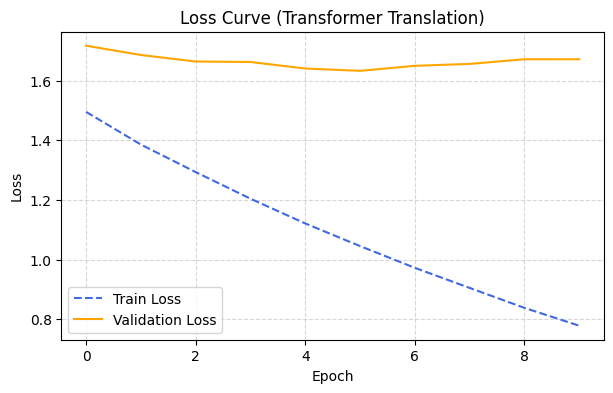

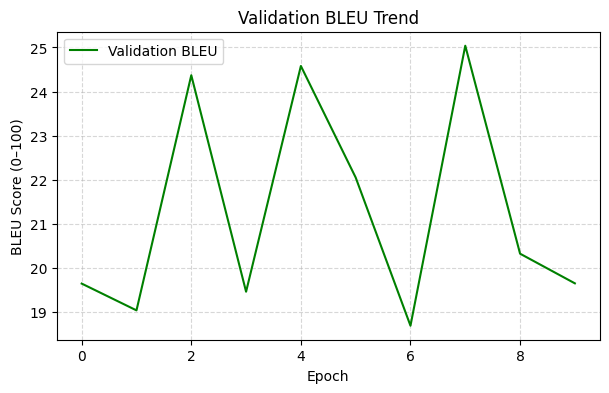

In [17]:
# ============================================
# 119. Greedy Decoding 함수
# ============================================

@torch.no_grad()
def greedy_decode(model, src, src_mask, max_len, start_symbol, end_symbol):
    """
    src: [1, S]
    src_mask: [S, S]
    """
    src = src.to(device)
    memory = model.transformer.encoder(
        model.pos_encoder(model.src_emb(src)),
        src_key_padding_mask=(src == SRC_PAD_IDX)
    )

    # 디코더 입력의 시작은 <bos>
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)

    for i in range(max_len - 1):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
        tgt_emb = model.pos_encoder(model.tgt_emb(ys))
        out = model.transformer.decoder(
            tgt_emb, memory,
            tgt_mask=tgt_mask,
            memory_key_padding_mask=(src == SRC_PAD_IDX)
        )
        out = model.generator(out[:, -1])  # 마지막 단어 예측
        next_word = out.argmax(dim=1).item()

        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src)], dim=1)
        if next_word == end_symbol:
            break

    return ys


def translate(model, src_sentence):
    model.eval()

    # 입력 문장 소문자 처리
    src_sentence = src_sentence.lower()

    # 토큰화 + 인덱스로 변환 (없는 단어는 <unk>)
    src_tokens = [SRC_BOS_IDX] + [
        src_vocab[token.text] if token.text in src_vocab else src_vocab['<unk>']
        for token in nlp_de(src_sentence)
    ] + [SRC_EOS_IDX]

    src_tensor = torch.LongTensor(src_tokens).unsqueeze(0).to(device)

    # 마스크 생성
    num_tokens = src_tensor.size(1)
    src_mask = torch.zeros(num_tokens, num_tokens, dtype=torch.bool).to(device)

    # greedy decoding
    tgt_tokens = greedy_decode(
        model, src_tensor, src_mask, max_len=50,
        start_symbol=TGT_BOS_IDX,
        end_symbol=TGT_EOS_IDX
    ).flatten()

    # index → token 복원
    tgt_itos = {v: k for k, v in tgt_vocab.items()}  # 인덱스 → 단어 변환
    translated = " ".join([tgt_itos.get(tok, "<unk>") for tok in tgt_tokens.cpu().numpy()])

    # <bos>, <eos> 제거
    return translated.replace("<bos>", "").replace("<eos>", "").strip()


# 테스트 문장 예시
test_sentences = [
    "Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.",
    "Ein Mann steht auf einer Leiter und putzt ein Fenster.",
    "Ein Mädchen spielt mit einem Hund im Garten.",
    "ich liebe dich.",
]

for s in test_sentences:
    print(f"\n[독일어] {s}")
    print(f"[영어 번역] {translate(model, s)}")



[독일어] Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
[영어 번역] two young white males are outside near bushes .

[독일어] Ein Mann steht auf einer Leiter und putzt ein Fenster.
[영어 번역] a man is standing on a ladder cleaning a window .

[독일어] Ein Mädchen spielt mit einem Hund im Garten.
[영어 번역] a girl is playing with a dog in the yard .

[독일어] ich liebe dich.
[영어 번역] i think <unk> to be seen .
